# S&P 500 Market Analysis
In this notebook, we'll be conducting a basic analysis of the S&P 500 stock market index. The goal is to understand its historical trends and use machine learning to predict whether the index will go up or down on the next trading day.

In [1]:
# Importing necessary libraries
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt

# Data Retrieval 
Lets start by fetching the historical data of the S&P 500 index. We will use the yfinance libary to get this data

In [2]:
# Retrieving the S&P 500 data
sp500 = yf.Ticker("^GSPC").history(period="max")
print(sp500.head())

                                Open       High        Low      Close  Volume  \
Date                                                                            
1927-12-30 00:00:00-05:00  17.660000  17.660000  17.660000  17.660000       0   
1928-01-03 00:00:00-05:00  17.760000  17.760000  17.760000  17.760000       0   
1928-01-04 00:00:00-05:00  17.719999  17.719999  17.719999  17.719999       0   
1928-01-05 00:00:00-05:00  17.549999  17.549999  17.549999  17.549999       0   
1928-01-06 00:00:00-05:00  17.660000  17.660000  17.660000  17.660000       0   

                           Dividends  Stock Splits  
Date                                                
1927-12-30 00:00:00-05:00        0.0           0.0  
1928-01-03 00:00:00-05:00        0.0           0.0  
1928-01-04 00:00:00-05:00        0.0           0.0  
1928-01-05 00:00:00-05:00        0.0           0.0  
1928-01-06 00:00:00-05:00        0.0           0.0  


# Data Visualization 
A basic line plot will give us an understanding of how the S&P 500 closing prices have evolved over time.

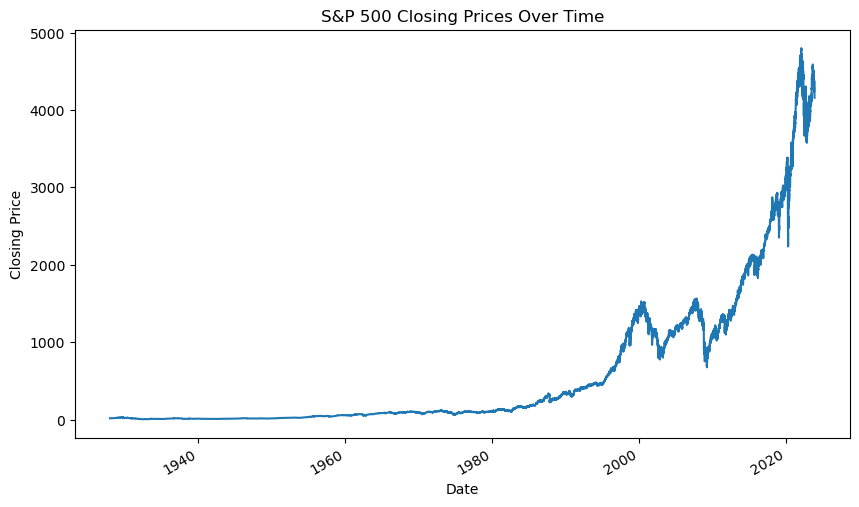

In [3]:
# Visualizing the closing prices
plt.figure(figsize=(10,6))
sp500['Close'].plot(title='S&P 500 Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

# Data Cleaning
Before diving into machine learning, let's clean our dataset by removing unnecessary columns and adding some derived columns that may be useful for our analysis.

In [4]:
# Data Cleaning
sp500.drop(columns=['Dividends', 'Stock Splits'], inplace=True)
sp500['Tomorrow'] = sp500['Close'].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500['Close']).astype(int)
sp500 = sp500.loc["1990-01-01":].copy()

# Model Training and Testing
We'll use a Random Forest classifier to predict if the S&P 500 index will go up or down the next day. The model will be trained on older data and tested on the most recent 100 days.

In [5]:
# Splitting, Model Initialization and Training
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]
predictors = ["Close", "Volume", "Open", "High", "Low"]

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

# Model Evaluation
To gauge our model's accuracy, we will evaluate its precision. Precision gives us an idea about the number of correct positive predictions made by the model out of all positive predictions.

In [6]:
# Prediction and Evaluation
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.49333333333333335

# Backtesting
Backtesting is a method used in the financial sector to evaluate the effectiveness of a trading strategy on historical data. If our model is to be used in a real-world scenario, it's essential to know how it would have performed in the past. Let's run our model on different periods of our dataset to simulate this.

In [7]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

# Backtesting function
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

predictions = backtest(sp500, model, predictors)


# Feature Engineering
Feature engineering is a vital step in the machine learning. By creating new features, we can capture more patterns and insights from the data. For our dataset, we will create new predictors based on rolling averages.

In [8]:
# Feature Engineering based on rolling averages
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]
    sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])


# Refining the Model
With our newly created features, let's retrain our Random Forest model to see if it performs better. We'll also adjust the prediction threshold for better performance.

In [9]:
# Updating the model with new features
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

# Redefining our predict function with threshold adjustments
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

# Combining old and new predictors
predictions = backtest(sp500, model, new_predictors)

# Final Evaluation
Let's evaluate the performance of our refined model with the additional features. We'll examine the precision score again to understand how well our model has improved with the new features.

In [10]:
print(f"Precision Score (Refined Model): {precision_score(predictions['Target'], predictions['Predictions'])}")

Precision Score (Refined Model): 0.5745140388768899


# Future Improvements
**Sector Analysis:** Diversifying our features by including data on different sectors like Tech and Healthcare could give us more insights. By examining the performance of major sectors, we might be able to derive patterns or relationships with the overall movement of the S&P 500.

**Incorporating News Sentiment:** News plays a big role in influencing stock market movements. By scraping daily headlines from sources like the New York Times, we could design a sentiment model. This model would assess the overall sentiment or mood of the news and create a 'Sentiment' indicator. Integrating this sentiment score as a predictor column might improve our model's predictive capabilities, as it will factor in the impacts of current events on market behavior.

# Overall Summary
In this project, we undertook the process of predicting movements in the S&P 500 stock index. We began by fetching the historical data of the S&P 500 using the yfinance library and proceeded to visualize its closing prices to gain a clearer understanding of its behavior over time.

We prepared the data by dropping unnecessary columns and introducing a target variable that represents the upward or downward movement of the closing prices. By using a RandomForestClassifier, we trained the model on the dataset's features and tested its performance using precision as our evaluation metric.

Additionally, we enhanced the model's accuracy by introducing feature engineering techniques, specifically rolling averages, and adjusting decision thresholds.